## Simulate White/Pink/Brown Noise MFDFA

White noise = $\frac{1}{f^{0}}$ 

Pink noise = $\frac{1}{f^{1}}$ 

Brownian noise = $\frac{1}{f^{2}}$

### Get 20 samples of each noise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorednoise as cn

In [2]:
colors = []
sigs = []

## for every color
for beta, color in zip([0, 1, 2], ['white', 'pink', 'brown']):
    ## generate 100
    for n in np.arange(0, 100):
        samples = 120000 # number of samples to generate
        sigs.append(cn.powerlaw_psd_gaussian(beta, samples))
        colors.append(color)

In [3]:
noises = pd.DataFrame(
    {
        'colors' : colors,
        'sigs' : sigs
    }
)

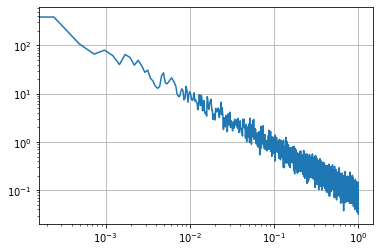

In [4]:
# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
from matplotlib import pylab as plt

y = noises[noises['colors'] == 'pink'].sigs.values[0]

s, f = mlab.psd(y, NFFT=2**13)
plt.loglog(f,s)
plt.grid(True)
plt.show()

## Apply MFDFA on noise simulations

In [5]:
import numpy as np
from starling_rhythm.mfdfa import hurst_expo
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm

/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
n_jobs = 36 ## set up joblib parameters
verbose = 0

In [7]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    h_expos = parallel(
        delayed(hurst_expo)(
            amp_env
        ) 
        for amp_env in tqdm(noises.sigs.values, desc = "Retrieving Hurst Exponents for All Noises.")
    )

Retrieving Hurst Exponents for All Noises.: 100%|██████████| 300/300 [01:50<00:00,  2.71it/s]


In [8]:
## Get MF_range
MF_range = []
for h_expo in h_expos:
    MF_range.append(max(h_expo) - min(h_expo))

In [9]:
noises['h_expo'] = h_expos
noises['MF_range'] = MF_range

In [10]:
noises.head()

,colors,sigs,h_expo,MF_range
0,white,"[0.5823877247104957, -1.1008584425208365, 0.50...","[0.5239743350978392, 0.5194510518730128, 0.515...",0.027740
1,white,"[0.6119429871016878, -0.6958102899188658, -1.2...","[0.5269208604378124, 0.5230158114367093, 0.519...",0.023482
2,white,"[-0.7357871524829459, 0.18979721091367696, 0.8...","[0.49990473640415856, 0.49604463459854214, 0.4...",0.023439
3,white,"[-0.9101376514716634, 1.6228755556969887, -0.3...","[0.5288018301454757, 0.524012738596473, 0.5199...",0.029324
4,white,"[-0.06819516075321415, -1.7235793268601478, -0...","[0.5113617386797836, 0.5075448605442294, 0.504...",0.022062


## Produce IAAFT surrogates

In [11]:
import starling_rhythm.iaaft as iaaft
from starling_rhythm.mfdfa import hurst_expo
from joblib import Parallel, delayed
from timeit import timeit
from tqdm.autonotebook import tqdm

In [12]:
def SDoMF_iaaft(amp_env, ns = 32):
    '''
    For each amplitude envelope, find some number of its surrogates, and find MF_range for all surrogates
    '''
    
    ## calculate its surrogates
    surrogates = iaaft.surrogates(amp_env, ns = ns, maxiter = 10000, verbose = True)
    
    ## container for SDoMF_iaaft
    SDoMF = []
    
    ## find all the Hurst exponents of all the surrogates
    for surrogate in surrogates:
        ## Output Hs for each surrogate
        h_expos = hurst_expo(surrogate)
        SDoMF.append(max(h_expos) - min(h_expos))
            
    return SDoMF

In [13]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    mf_ranges = parallel(
        delayed(SDoMF_iaaft)(
            amp_env
        )
        for amp_env in tqdm(noises.sigs.values, desc = 'Running Surrogate Data')
    )

Running Surrogate Data: 100%|██████████| 300/300 [58:09<00:00, 11.63s/it]


In [14]:
noises['mf_iaaft_range'] = mf_ranges

## Parse t-statistics

In [15]:
import scipy.stats as stats
import numpy as np

In [16]:
ts = []
p = []
for MF_range, mf_iaaft_range in zip(noises['MF_range'].values, noises['mf_iaaft_range']):
    test = stats.ttest_1samp(mf_iaaft_range, MF_range)
    ts.append(test[0])
    p.append(test[1])
    
noises['ts'] = ts
noises['p'] = p

In [17]:
import statsmodels.stats.multitest

In [18]:
bonferroni = statsmodels.stats.multitest.multipletests(noises['p'].values, alpha = 0.05, method = 'bonferroni')
noises['sig'] = bonferroni[0]
noises['bonf_p'] = bonferroni[1]

In [19]:
noises.head()

,colors,sigs,h_expo,MF_range,mf_iaaft_range,ts,p,sig,bonf_p
0,white,"[0.5823877247104957, -1.1008584425208365, 0.50...","[0.5239743350978392, 0.5194510518730128, 0.515...",0.027740,"[0.024027509480052, 0.024727299343870524, 0.02...",-4.681912,5.334253e-05,True,1.600276e-02
1,white,"[0.6119429871016878, -0.6958102899188658, -1.2...","[0.5269208604378124, 0.5230158114367093, 0.519...",0.023482,"[0.02546014140177666, 0.024367559090620716, 0....",2.331759,2.638578e-02,False,1.000000e+00
2,white,"[-0.7357871524829459, 0.18979721091367696, 0.8...","[0.49990473640415856, 0.49604463459854214, 0.4...",0.023439,"[0.020014108891869664, 0.021983566883790162, 0...",1.872472,7.060040e-02,False,1.000000e+00
3,white,"[-0.9101376514716634, 1.6228755556969887, -0.3...","[0.5288018301454757, 0.524012738596473, 0.5199...",0.029324,"[0.023997161129111433, 0.030014400604617353, 0...",-11.676565,6.990717e-13,True,2.097215e-10
4,white,"[-0.06819516075321415, -1.7235793268601478, -0...","[0.5113617386797836, 0.5075448605442294, 0.504...",0.022062,"[0.02447633327668275, 0.02592259280901399, 0.0...",5.202681,1.201126e-05,True,3.603379e-03


In [20]:
### Out of all noises, how many are significantly multifractal?
np.unique(noises[noises['colors'] == 'white']['sig'].values, return_counts = True) 

(array([False,  True]), array([56, 44]))

<AxesSubplot:xlabel='ts', ylabel='Density'>

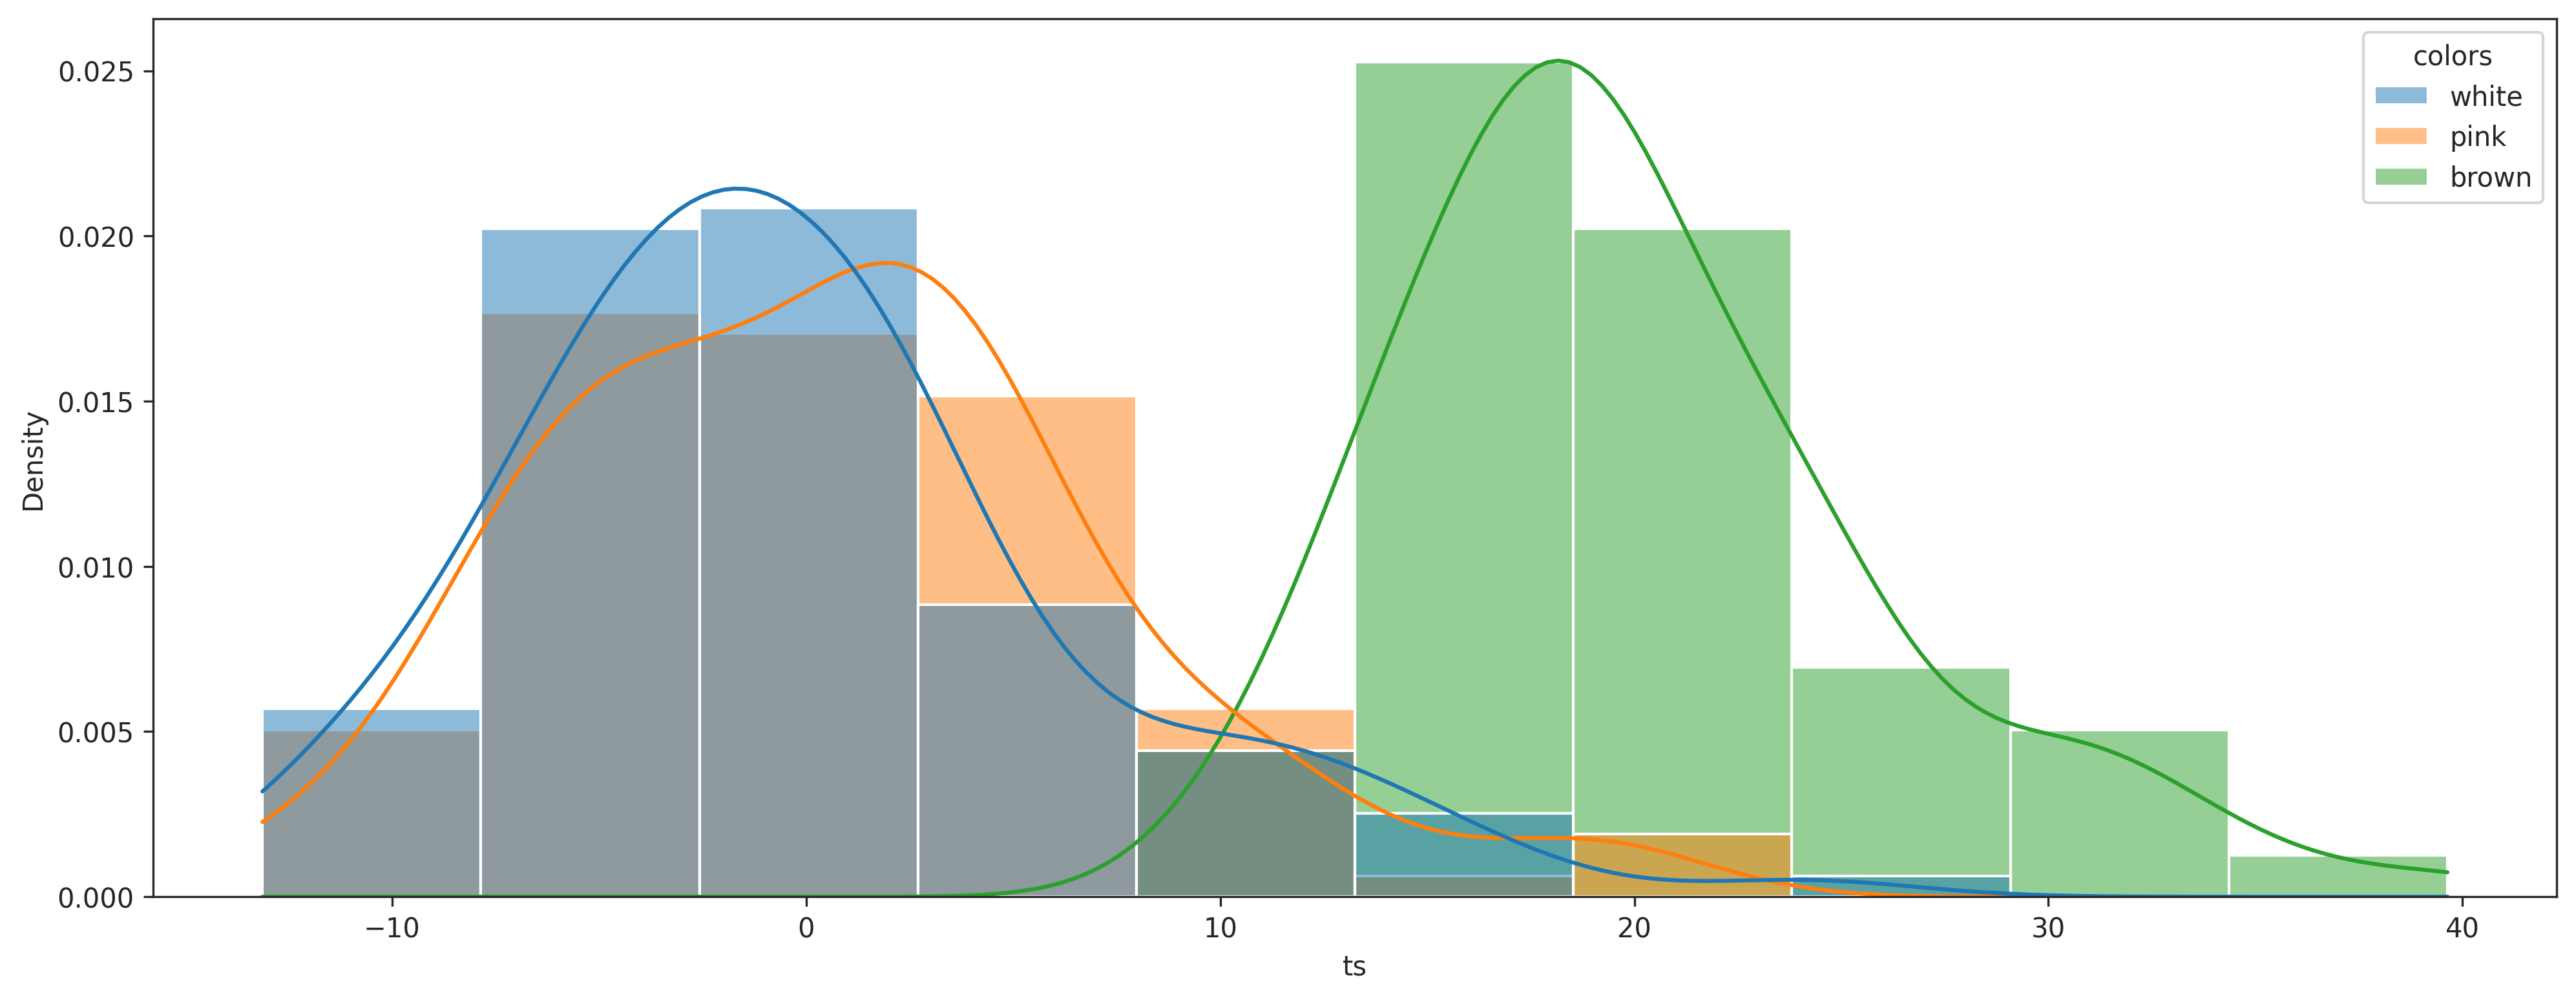

maximum number of iterations reached!
maximum number of iterations reached!
maximum number of iterations reached!


In [21]:
### distribution?
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['patch.edgecolor'] = 'none'
figure(figsize = (16, 6), dpi = 300)
sns.set_style('ticks')

sns.histplot(data = noises, x = 'ts', stat = 'density', color = 'black', hue = 'colors', kde = True)